# Predicting Advertisement Response

## Objective

This notebook aims to analyze the factors influencing residents' responses to advertisements and build a predictive model. We will explore the relationships between residents' characteristics and their likelihood of responding positively to an advertisement sent by mail. Ultimately, we'll develop a data-driven model that can accurately predict whether a resident will respond to the advertisement.

## Dataset Overview

The dataset contains information about residents who received advertisements through the mail. It includes their demographic and lifestyle information, along with a response indicator to denote whether they replied positively to the advertisement. The features in the dataset are as follows:

- **age**: Age of the resident.
- **lifestyle**: Lifestyle category of the resident.
- **ZIP code**: ZIP code indicating the area where the resident lives.
- **family status**: Marital or family status of the resident (e.g., single, married).
- **car**: Type of car the resident owns (if any).
- **sports**: Preferred sport of the resident.
- **earnings**: Annual earnings of the resident.
- **living area**: Type of area where the resident lives (e.g., urban, suburban).
- **label**: Target variable indicating the resident's response to the advertisement ("response" or "no response").

Our goal is to better understand the correlation between each of these features and the residents' responses, and to create a machine learning model that predicts a Yes/No response for future residents based on their specific features.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1)
from random import sample
from sklearn import preprocessing, manifold, tree
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from graphviz import Source

## Data Preparation

In [2]:
# Loading the data from the CSV file
df = pd.read_csv('data/ads_data.csv')
df.drop(columns = 'name', axis = 1, inplace= True)
df.head(6)

,age,lifestyle,zip code,family status,car,sports,earnings,living area,label
0,62.0,cozily,50168.0,married,practical,athletics,102526.0,urban,no response
1,34.0,active,66479.0,married,expensive,soccer,33006.0,urban,no response
2,69.0,healthy,16592.0,single,expensive,badminton,118760.0,urban,response
3,57.0,cozily,50068.0,married,practical,soccer,131429.0,urban,response
4,66.0,cozily,35988.0,single,practical,badminton,96003.0,urban,response
5,21.0,healthy,60039.0,single,expensive,badminton,83376.0,urban,no response


In [3]:
# Simplifying feature names 
columns = df.columns.values
columns[2] ="ZipCode"
df.columns = columns

# Changing from float to int for integer values
df.age = df.age.astype(int)
# df.earnings = df.earnings.apply(int)
df.earnings = df.earnings.astype(int)
df.ZipCode = df.ZipCode.astype(int)

# Separating category-based features from numerical features
categorial, numerical = [], []
for col in df.columns:
    if df[col].dtype in ['float64', 'int']:
        numerical.append(col)
    else:
        categorial.append(col)

## Analyzing the Distribution of Individual Features
The following figures show the distribution of values for each of the features ("age," "lifestyle", ...). We can observe that all feature values have almost uniform distributions, which is a positive aspect regarding the collected data's quality. 
In other words, the target groups are equally selected from various groups considering the lifestyle, earning level, residential area, and other features.

However, we see that the number of people who didn't respond to your advertisements is twice the responsive groups. 
We will work on changing this ratio through our professional and domain-specific consulting.

Text(0.52, 0.071, 'The distribution of input features for the given data. Almost all features are uniformly distributed over their value ranges.')

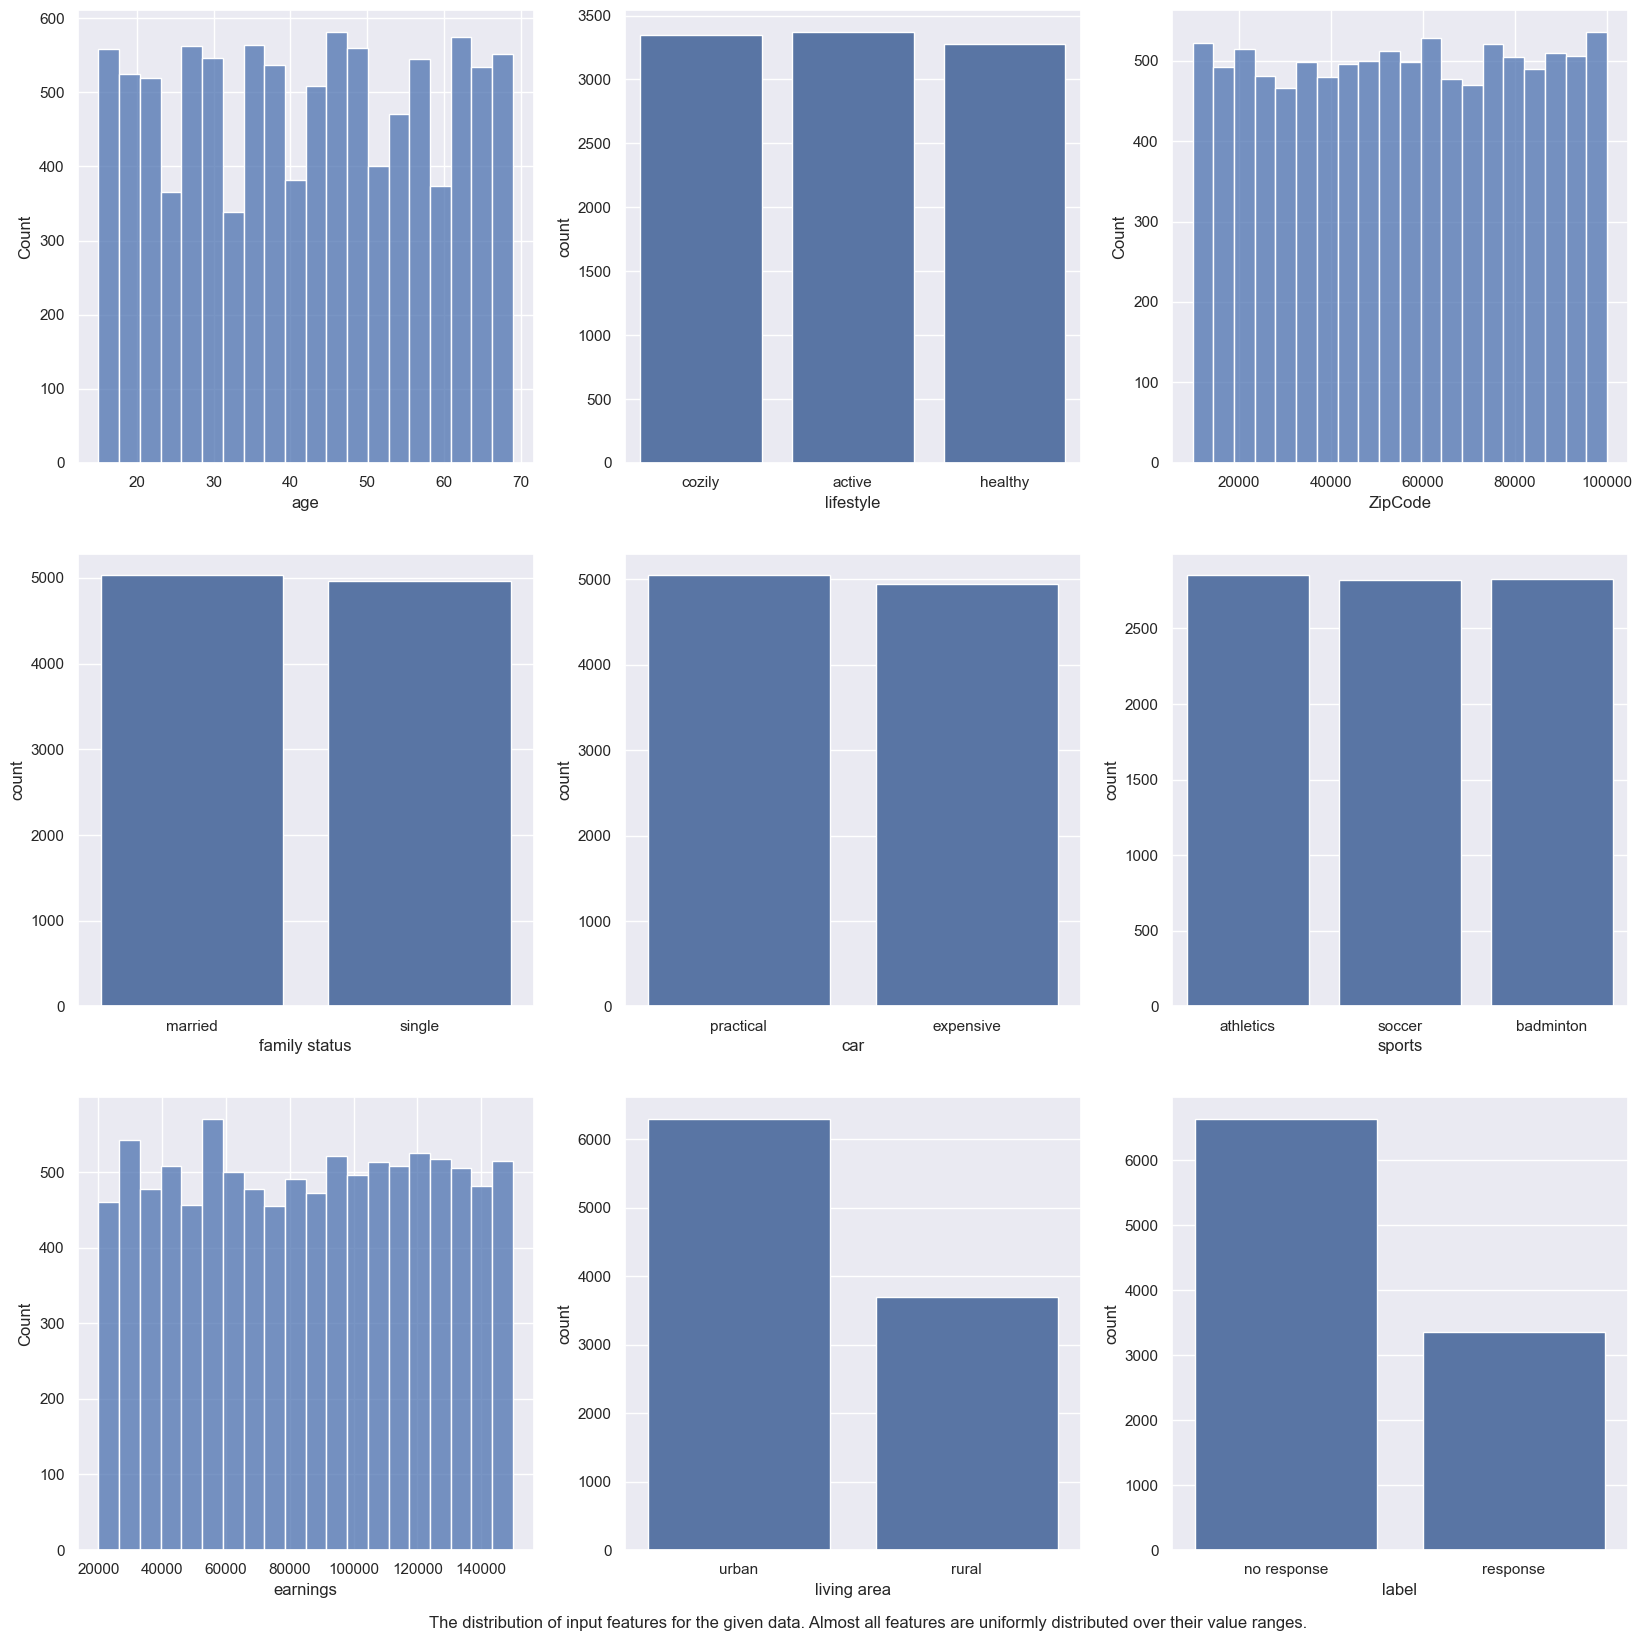

In [4]:
# Ploting the feature distributions
fig, ax = plt.subplots(3,3 , figsize=(20, 20))
for cat, ax_i in zip(df.columns, ax.flatten()):
    if cat in categorial:
        sns.countplot(x=cat, data=df, ax=ax_i)
    else:
        sns.histplot(data = df, x= cat, kde=False, bins=20, ax=ax_i)  
txt="The distribution of input features for the given data. Almost all features are uniformly distributed over their value ranges."
fig.text(.52, 0.071, txt, ha='center')        

In [5]:
# Balancing the classes regarding their number of samples
len_pos = len(df[df.label == "response"])
ind_neg = df.label != "response"
len_neg = len(df[ind_neg])
neg_sub = sample(range(len_neg),len_neg-len_pos)
ind_drop = df[ind_neg].iloc[neg_sub].index
df_orig = df.copy() # Having a backup from df before droping selected rows
df.drop(ind_drop, inplace = True)
df_balance = df.copy()

## Analyzing the Response Rates
In the following set of figures, we observe the distribution of "response" and "no response" cases over various personal features. In other words, we can investigate to what extent each of these features can be related to receiving a response from the client.

### Irrelevant Features:
As we can see, there is no specific trend that we can find in *lifestyle*, *family status*, *car*, *sports*, and *living area* in connection to the response result.
For instance, almost the same number of people living in the rural areas responded to the advertisements compared to the rest of the target group living there.
Hence, my professional advice is to remove these features from your data collection pipeline, specifically if their acquisition is relatively expensive.

Text(0.3, 0.081, "The distribution of responses over the range of each input feature. Except for *age*, *earnings*, and *ZIP code*,\n both 'response' and 'no response' cases have similar distributions over the input ranges.")

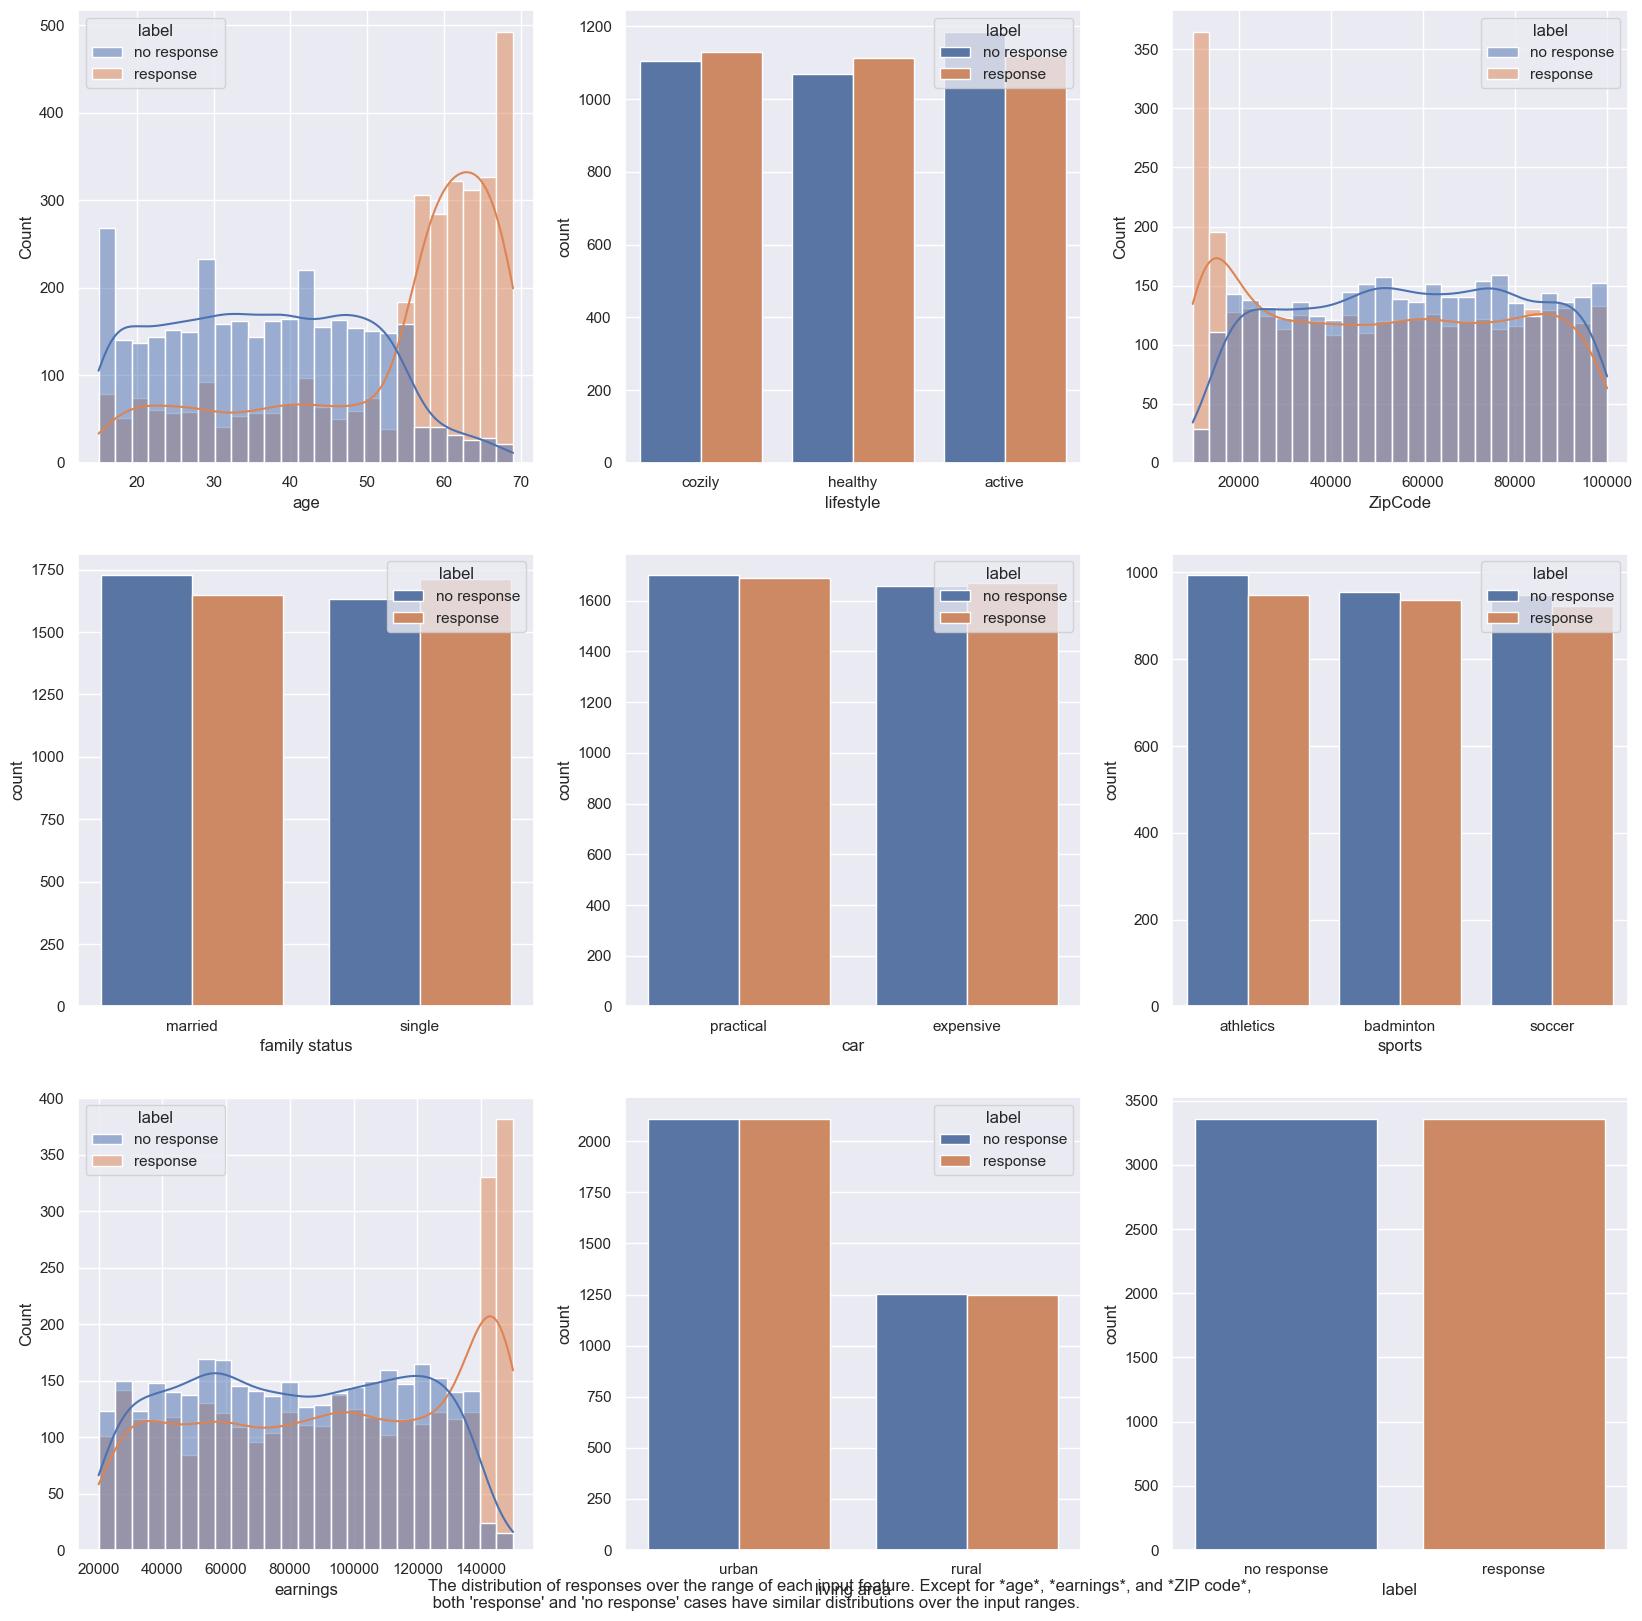

In [6]:
# Distribution of classes regarding each individual feature
fig, ax = plt.subplots(3,3 , figsize=(20, 20))
for cat, ax_i in zip(df.columns, ax.flatten()):
    if cat in categorial:
        sns.countplot(x=cat, data=df, hue='label', ax=ax_i)        
    else:
        sns.histplot(data = df, x= cat, kde=True, bins=25, ax=ax_i, hue= 'label')
txt="The distribution of responses over the range of each input feature. Except for *age*, *earnings*, and *ZIP code*,\n both 'response' and 'no response' cases have similar distributions over the input ranges."
fig.text(.3, 0.081, txt, ha='left')

### Relevant Features:
On the other hand, we can observe significant trends in *age*, *zip code*, and *earnings*, which tell us more about the most probable groups to respond to your advertisements. These observations are as follow:

* According to the *age* figure, the senior people are more responsive than younger ones. 

* The *earning* pattern shows that the minority of individuals who have incomes higher than 140K are most likely to reply to you.

* Based on the *zip code* information, we see that people who live in a particular small residential area show more interest in your advertisements than the rest of the target clients.

The following figures study the above fundings in more detail.

Text(0.5, -0.05, "Distribution of 'age', 'earnings', and 'ZipCode' columns vs each other while also considering the response data.")

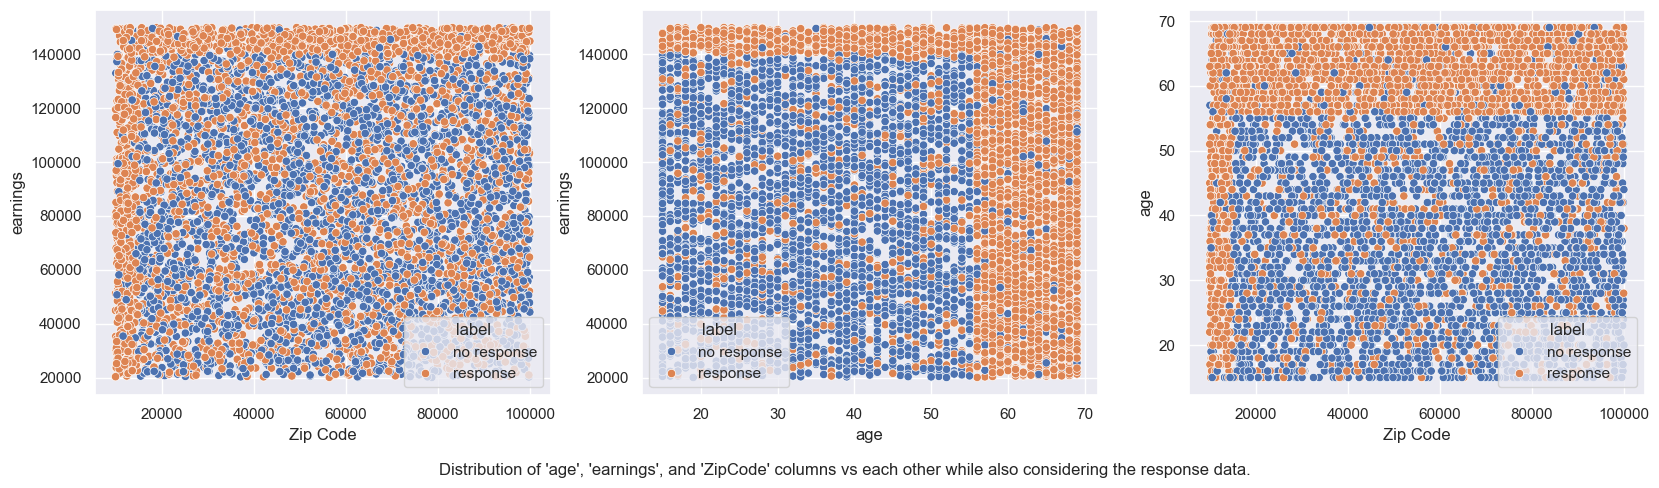

In [7]:
# Ploting 'age', 'earnings', and 'ZipCode' columns vs each other 
fig, ax = plt.subplots(1,3 , figsize=(20, 5))
sns.scatterplot(data= df, x = 'ZipCode', y= 'earnings', hue='label', ax=ax[0]).set(xlabel = 'Zip Code')
sns.scatterplot(data= df, x = 'age', y= 'earnings', hue='label', ax=ax[1])
sns.scatterplot(data= df, y = 'age', x= 'ZipCode', hue='label', ax=ax[2]).set(xlabel = 'Zip Code')
txt="Distribution of 'age', 'earnings', and 'ZipCode' columns vs each other while also considering the response data."
fig.text(.5, -0.05, txt, ha='center')

The following figure provides a more detailed analysis of the most potential target groups for sending back responses to your advertisements. 
Accordingly, I summarize the existing response trends as follows:

1. Approximately 92 out of every 100 individuals who are older than 56 will respond.
2. You can expect that around 96% of the people who earn higher than 140K would reply to you.
3. You have a 92% chance of receiving responses for advertisements that you send to the areas with ZIP codes smaller than 14000.  


The above figures show that there isn't any specific correlation between those particular features that could direct us toward a particular combination of the above points.
For instance, senior people and wealthier individuals responsive to the advertisements are almost equally distributed in all residential areas.

Text(0.5, -0.05, "Responses ratios in relevant parts of 'age', 'earnings', and 'ZipCode' distributions.")

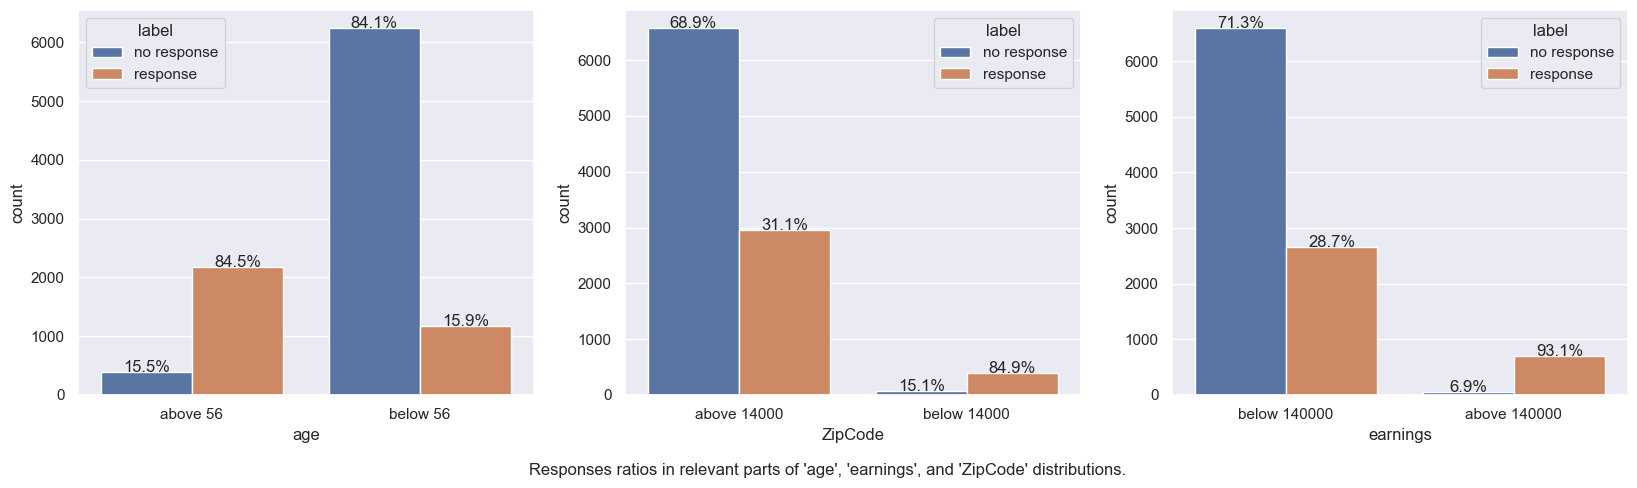

In [8]:
# Ploting the amount of responses in sgnificant areas of 'age', 'earnings', and 'ZipCode' distributions.
df_cat = df_orig.copy()
fig, axs = plt.subplots(1,3, figsize = (20,5))
cats = ['age','ZipCode', 'earnings']
thresholds = [56,14000,140000]

def cat_df_modif(df,cat,thresh):
    indx = (df[cat] < thresh).values
    df[cat] = df[cat].astype(str)  # Explicitly cast to string type
    df.loc[indx,cat] = "below {}".format(thresh)
    df.loc[~indx,cat] = "above {}".format(thresh)
    return df

# loop of plotting
for cat,thresh,ax in zip(cats,thresholds, axs.flatten()):
    df_cat = cat_df_modif(df_cat,cat, thresh)
    sns.countplot(x=cat, data=df_cat, hue='label', ax=ax)
    perc = np.zeros(4)
    
    # Calculating the ratios and adding them to the bars
    for i in range(2):
        sum_p = sum(ax.patches[j].get_height() for j in [i,i+2])/100
        perc[i] = ax.patches[i].get_height() /sum_p
        perc[i+2] = ax.patches[i+2].get_height() / sum_p
    [ax.annotate('{:.1f}%'.format(perc[ip]), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center') for ip, p in enumerate(ax.patches[0:4])]
txt="Responses ratios in relevant parts of 'age', 'earnings', and 'ZipCode' distributions."
fig.text(.5, -0.05, txt, ha='center')    

## Response Prediction Model

Using the data you have provided, we designed the following model (Decision Tree) to predict a resident's reaction to the advertisement you would send him/her. 
The following steps train the model based on the above relevant information features *age*, *zip code*, and *earnings*.

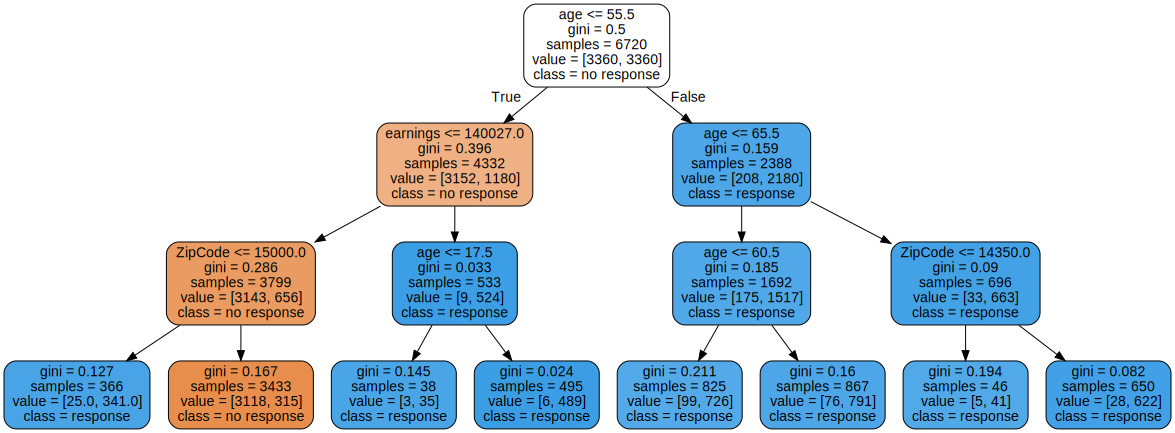

In [9]:
# training the decision tree
# selecting the relevant features
x =  df[['age','ZipCode','earnings']].values
y = df.label.values
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

model = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf = 10) # preventing overlapping
model.fit(x,y)
# visualizing the trained DT
dot_data = tree.export_graphviz(model, out_file=None,
                                    feature_names=['age','ZipCode','earnings'],
                                    class_names= le.classes_,
                                    filled=True, rounded=True)
graph = Source(dot_data, format="png")
graph

The designed data-driven model makes its prediction based on the specific 3 points mentioned earlier about the significant parts of the *age*, *zip code*, and *earnings* distributions. 
This model has a prediction accuracy of 92%, i.e., for every 100 cases, it correctly predicts the reaction of the target resident.
Based on its recall value, the model correctly identifies 90 cases out of each 100 (assumingly) responsive individuals given to it.

In [10]:
# Evaluating the DT model in a cross-validation setting
y_pred = cross_val_predict(model, x, y, cv=20)
acc = accuracy_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
print('Prediction accuracy of the model: {:.2f}%'.format(100*acc))
print('True positive rate (Recall): {:.2f}%'.format(100*tp/(tp+fn)))
f1_sc = f1_score(y, y_pred, average='weighted')
print('True f1 score of the prediction : {:.2f}'.format(f1_sc))

Prediction accuracy of the model: 91.71%
True positive rate (Recall): 90.62%
True f1 score of the prediction : 0.92


## Business Recommendations

Our analysis shows that you have more responses from people of particular *age*, *wealth*, and *zip code* groups. Hence, you can better plan on how to direct your advertisement costs and efforts toward specific groups. 

Despite the above findings, the following pie charts show that the determined groups only form a minority portion of all potential residents who respond to the advertisements. For instance, more than 85% of responsive people are distributed among areas with ZIP codes larger than 14000. However, at the moment, only 1 out of 3 advertisements in those areas bring a response. Therefore, I have the following recommendations to improve your advertisement system:

1. Senior people better received your advertisements. Therefore, to better attract the younger groups, we advise reconsidering the advertisement design or your products' age-related applications.

2. You have responses only from a narrow portion of the residential areas (ZIP code < 14000). However, people's age and income are almost equally distributed over different residential areas. So, there is no underlying correlation in the available data to justify this observation. Hence, I strongly recommend you investigating the cause of this area-specif response.

3. Your advertisements or your products are appealing more to people with high incomes. So, It would be more effective if you choose your advertising targets according to your services/products' price category. 

4. Our analysis revealed that the influencing parameters in people's reaction are their *age*, *earnings*, and *residential area*. Therefore, a more effective advertising strategy is to categorize the advertisements or products according to the mentioned features. 

5. I suggest that you provide us additional features such as the time (month/date) of the advertisement, the product category, and the history of responses per resident (if available).

[None]

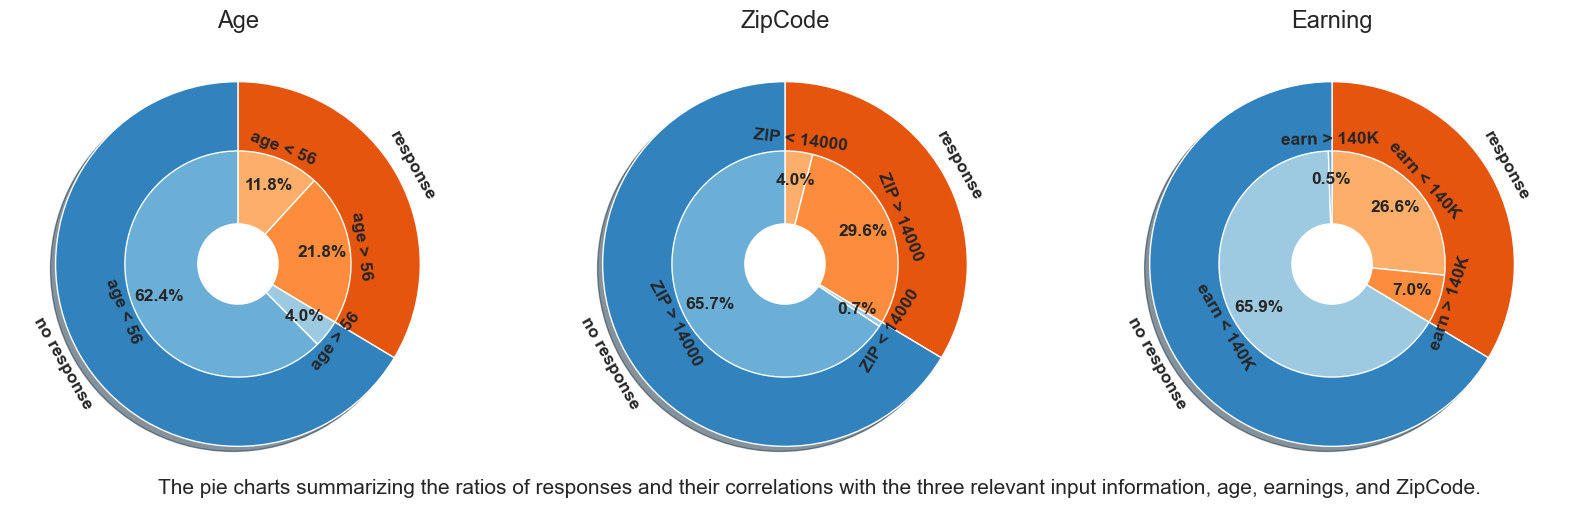

In [11]:
# Preparing pie charts to have an overview on important ratios of 'responses' vs the 3 relevant features.
df = df_orig.copy()
# calclating the important parts of the data
mapping = {'response':1, 'no response':0}
df = df.replace({'label':mapping})
cats = ['age','ZipCode', 'earnings']
thresholds = [56,14000,140000]
def cat_data(cat, threshold): # calculates the ratios per category 
    cat_l_pos = len(df[(df[cat] < threshold) & (df.label == 1)])
    cat_l = len(df[(df[cat] < threshold)])
    cat_g_pos = sum(df.label == 1) - cat_l_pos    
    cat_g = len(df)-cat_l
    data_in = [cat_l_pos, cat_g_pos, cat_l - cat_l_pos, cat_g - cat_g_pos]
    threshold = '140K' if cat == 'earnings' else threshold
    cat = 'ZIP' if cat == 'ZipCode' else 'earn' if cat == 'earnings' else cat
    labels_in = ['{} < {}'.format(cat,threshold), '{} > {}'.format(cat,threshold)]*2
    if cat == 'age':
        data_in[2],data_in[3] = data_in[3],data_in[2]
        labels_in[2],labels_in[3] = labels_in[3],labels_in[2]
    return data_in, labels_in

# preparing the figure settings
cmap = plt.get_cmap("tab20c")
colors = cmap([4,0])
colors_in = cmap([6,5,2,1])
sizes = [(df.label==1).sum(), len(df)-(df.label==1).sum()]
titles = ['Age', 'ZipCode', 'Earning']

# loop of plotting the charts
fig, ax = plt.subplots(1,3, figsize = (20,20))
size = 0.4
for i_p, ax_i in zip(range(3),ax):
    cat, threshold = cats[i_p], thresholds[i_p]
    data_in, labels_in = cat_data(cat, threshold)
    # Plot
    pie1 = ax_i.pie(sizes, labels=mapping.keys(), colors=colors, startangle=90, frame=False, radius=1, 
                    wedgeprops=dict(width=size, edgecolor='w'), rotatelabels =True, counterclock=False,shadow=True )
    pie2 = ax_i.pie(data_in, labels = labels_in, colors=colors_in, startangle=90, radius=.62, autopct='%1.1f%%',
            labeldistance = 1.1, pctdistance =.75, wedgeprops=dict(width=size, edgecolor='w'), rotatelabels =True,counterclock=False)

    plt.setp(pie1[1], rotation_mode="anchor", ha="center", va="center")
    # rotating the labels for better visualization
    for tx in pie1[1]:
        rot = tx.get_rotation()
        tx.set_rotation(rot + 90 + (1 - rot // 180) * 180)
    plt.setp(pie1[1], **{'weight': 'bold', 'fontsize': 12.5})
    ax_i.set_title(titles[i_p], fontdict={'fontsize': 17})

    plt.setp(pie2[1], rotation_mode="anchor", ha="center", va="center")
    for tx in pie2[1]:
        rot = tx.get_rotation()
        tx.set_rotation(rot + 90 + (1 - rot // 180) * 180)
    plt.setp(pie2[1:3], **{'weight':'bold', 'fontsize':12.5})
txt="The pie charts summarizing the ratios of responses and their correlations with the three relevant input information, age, earnings, and ZipCode."
fig.text(.53, 0.38, txt, ha='center').set(fontsize = 15)     

## Supplementary Material - Technical Analysis (for the technical audience)
In the following parts, some additional analyses are provided __only for technical people__ who might be interested in these aspects. 
You can consider it as supplementary material for this task. These extra analyses consist of:

* investigating the feature relevance of the given task using random forest
* 2-dimensional embedding of the data showing the neighborhood-based distribution of the classes
* Searching for the best depth for DT using cross-validation
* Studying any possible feature correlations

In [12]:
# converting strings to numbers
df = df_orig.copy()
mapping = list()
for index, cat in enumerate(categorial):
    if cat != 'label':
        d_un = df[cat].unique()    
        mapping.append({d_un[i]:i for i in range(len(d_un))})
        df = df.replace({cat:mapping[index]})

In [13]:
# feature relevance using random forest
x = df.drop('label', axis =1).values
y = df.label.values
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
# RF model
model = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=1)
model.fit(x,y)
# Obtaining the relevance profile
rel = model.feature_importances_
rel_profile = {cat:format(rl,'.2f') for cat,rl in zip(df.columns[:-1].values,rel)}
print('Feature relevance profile:\n',rel_profile)

Feature relevance profile:
 {'age': '0.57', 'lifestyle': '0.01', 'ZipCode': '0.16', 'family status': '0.00', 'car': '0.00', 'sports': '0.01', 'earnings': '0.24', 'living area': '0.00'}


Text(0.53, 0.05, '2D t-SNE visualization of the data which shows local clusters of the positive class.')

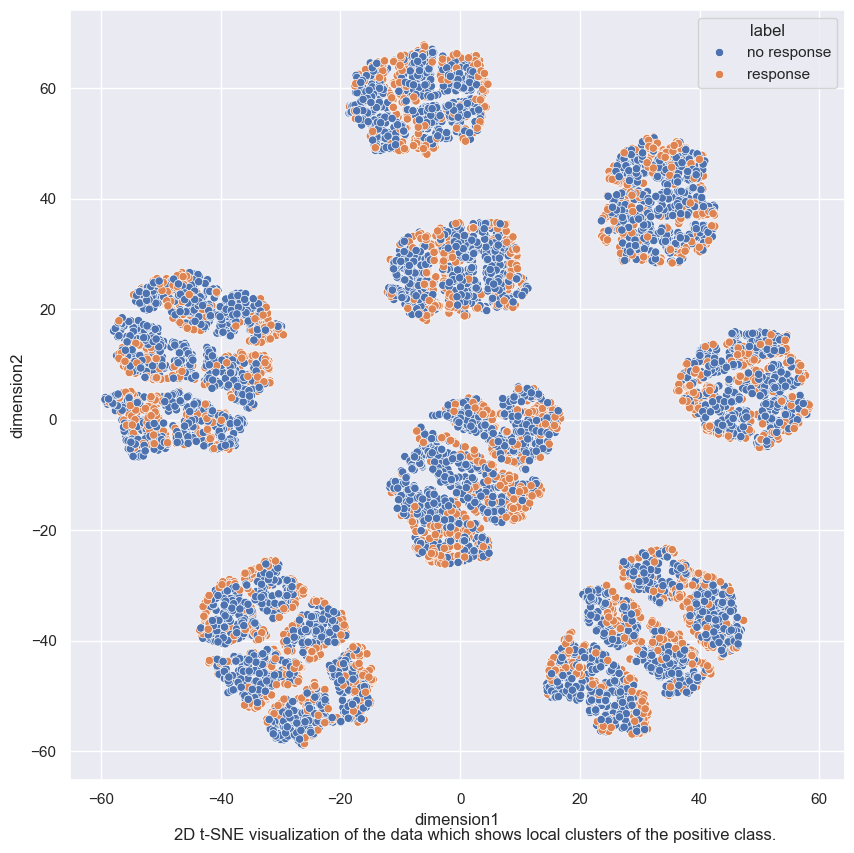

In [14]:
# 2D embedding of the data showing the local neighborhoods of the positive class
method = manifold.TSNE(n_components=2, perplexity = 100)
scaler = StandardScaler()
x_sc = scaler.fit_transform(x)
x_red = method.fit_transform(x_sc)

fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(x = x_red[:, 0], y = x_red[:, 1], hue=df.label).set(xlabel = 'dimension1', ylabel = 'dimension2')
# plt.title("2D t-SNE visualization of the data")
txt="2D t-SNE visualization of the data which shows local clusters of the positive class."
fig.text(.53, 0.05, txt, ha='center')

DT score:0.84%,  depth: 1
DT score:0.89%,  depth: 2
DT score:0.92%,  depth: 3
DT score:0.92%,  depth: 4
DT score:0.92%,  depth: 5
DT score:0.92%,  depth: 6
DT score:0.92%,  depth: 7
DT score:0.91%,  depth: 8
DT score:0.91%,  depth: 9
Best score:0.92%, best dep = 3


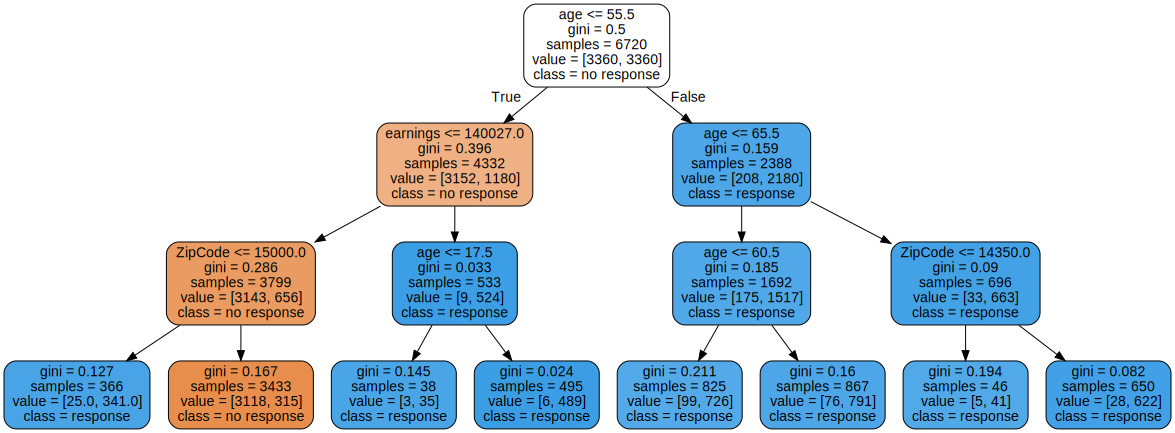

In [18]:
# Training the decision tree on the complete data set and searching for the best depth
x = df.drop(['label'], axis =1).values
y = df.label.values
acc_best = 0
dep_best =1
# loop of different depth values
for dep in range(1,10):
    decision_tree = tree.DecisionTreeClassifier(max_depth=dep, min_samples_leaf = 10)
    scores = cross_validate(decision_tree, x, y, scoring = 'accuracy', cv=20)
    acc = scores['test_score'].mean()
    acc_best, dep_best = (acc,dep) if acc>acc_best else (acc_best,dep_best)
    print('DT score:{:.2f}%,  depth: {}'.format(scores['test_score'].mean(), dep))

print('Best score:{:.2f}%, best dep = {}'.format(acc_best, dep_best))
# visualizing the trained tree with the best depth
model = tree.DecisionTreeClassifier(max_depth=dep_best)
model.fit(x,y)
dot_data = tree.export_graphviz(model, out_file=None,
                                    feature_names=df.columns[:-1].values,
                                    class_names= le.classes_,
                                    filled=True, rounded=True)
graph

Text(0.45, 0.1, 'The correlation matrix representing the pairwise correlation of input features.')

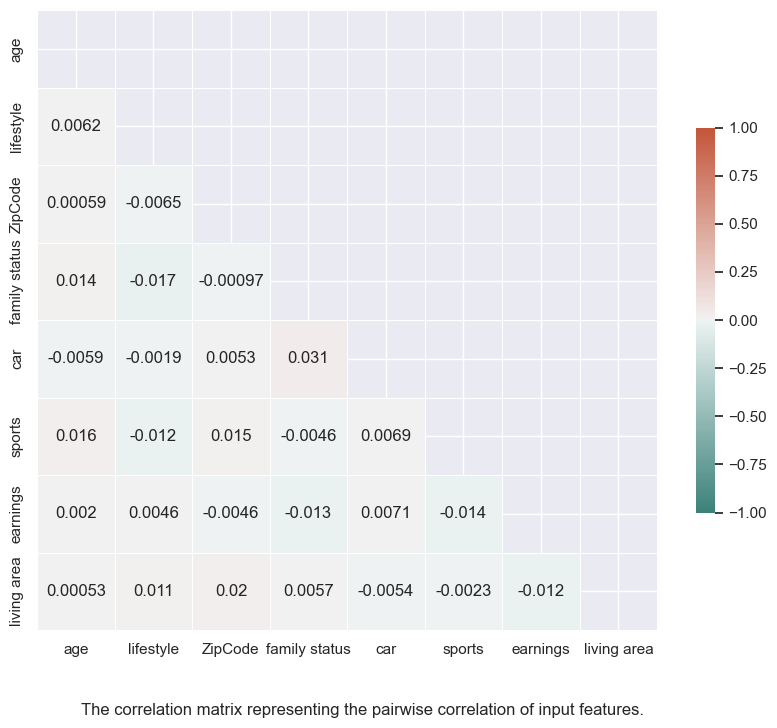

In [20]:
# feature correlations which shows no correlation among the input features
correlation = df.drop('label', axis =1).corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# ploting the feature relevance matrix
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
txt="The correlation matrix representing the pairwise correlation of input features."
fig.text(.45, 0.1, txt, ha='center')